The provided code block is an alternative installation approach for the `talib` library in Python. It is used when the standard installation using a wheel fails to compile, likely due to missing dependencies or incompatible configurations.

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4259    0  4259    0     0   4217      0 --:--:--  0:00:01 --:--:--  4221
100  517k  100  517k    0     0   183k      0  0:00:02  0:00:02 --:--:--  382k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4275    0  4275    0     0   4536      0 --:--:-- --:--:-- --:--:--  4533
100  392k  100  392k    0     0   151k      0  0:00:02  0:00:02 --:--:--  401k


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from IPython.display import display, clear_output

# Standard and Utility libraries
from pathlib import Path
from time import time
from collections import deque
from random import sample
import logging
import tempfile
import gc

# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale

# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Reinforcement Learning - OpenAI Gym
import gym
from gym.envs.registration import register
from gym import spaces
from gym.utils import seeding

# Technical Analysis Library
import talib
from scipy.stats import skew, kurtosis, norm

The Wiki Prices dataset is a substantial collection of intraday market data from the NASDAQ, obtained through the Quandl library. With a size of 1.7 GB, this dataset encompasses detailed timestamped information on trading activities, including prices and volumes for individual trades across various assets listed on the NASDAQ stock exchange.


In [ ]:
df = (pd.read_csv('/content/drive/MyDrive/Machine Learning/Data/WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info(null_counts=True))

DATA_STORE = Path('assets.h5')
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/prices', df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Data columns (total 12 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         15388776 non-null  float64
 1   high         15389259 non-null  float64
 2   low          15389259 non-null  float64
 3   close        15389313 non-null  float64
 4   volume       15389314 non-null  float64
 5   ex-dividend  15389314 non-null  float64
 6   split_ratio  15389313 non-null  float64
 7   adj_open     15388776 non-null  float64
 8   adj_high     15389259 non-null  float64
 9   adj_low      15389259 non-null  float64
 10  adj_close    15389313 non-null  float64
 11  adj_volume   15389314 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ GB
None


# Reinforcement Learning for Trading - Deep Q-learning & the stock market

To train a trading agent, we need to create a market environment that provides price and other information, offers trading-related actions, and keeps track of the portfolio to reward the agent accordingly.

The OpenAI Gym allows for the design, registration, and utilization of environments that adhere to its architecture, as described in its [documentation](https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym).

The trading environment consists of three classes that interact to facilitate the agent's activities:
 1. The `DataSource` class loads a time series, generates a few features, and provides the latest observation to the agent at each time step.
 2. `TradingSimulator` tracks the positions, trades and cost, and the performance. It also implements and records the results of a buy-and-hold benchmark strategy.
 3. `TradingEnvironment` itself orchestrates the process.

## A basic trading game

To train the agent, we need to set up a simple game with a limited set of options, a relatively low-dimensional state, and other parameters that can be easily modified and extended.

More specifically, the environment samples a stock price time series for a single ticker using a random start date to simulate a trading period that, by default, contains 252 days, or 1 year. The state contains the (scaled) price and volume, as well as some technical indicators like the percentile ranks of price and volume, a relative strength index (RSI), as well as 5- and 21-day returns. The agent can choose from three actions:

- **Buy**: Invest capital for a long position in the stock
- **Flat**: Hold cash only
- **Sell short**: Take a short position equal to the amount of capital

The environment accounts for trading cost, which is set to 10bps by default. It also deducts a 1bps time cost per period. It tracks the net asset value (NAV) of the agent's portfolio and compares it against the market portfolio (which trades frictionless to raise the bar for the agent).

We use the same DDQN agent and neural network architecture that successfully learned to navigate the Lunar Lander environment. We let exploration continue for 500,000 time steps (~2,000 1yr trading periods) with linear decay of ε to 0.1 and exponential decay at a factor of 0.9999 thereafter.


In [ ]:
# Step 1: "Let there be logs!" - Programmer Genesis 1:3
logging.basicConfig()
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
# Oh, you're logging? Tell me again how cutting-edge you are.
log.info('%s logger started.', __name__)

# Alright, back to serious stuff.
class DataSource:
    """
    Data source for TradingEnvironment

    Loads & preprocesses daily price & volume data
    Provides data for each new episode.
    Stocks with longest history:

    ticker  # obs
    KO      14155
    GE      14155
    BA      14155
    CAT     14155
    DIS     14155

    """

    def __init__(self, trading_days=252, ticker='AAPL', normalize=True):
        # Let's give it up for Apple! Apple a day keeps the bugs away.
        # Also, why 252 trading days? No vacation for Wall Street?
        self.ticker = ticker
        self.trading_days = trading_days
        self.normalize = normalize
        self.data = self.load_data()
        # I like my data like I like my coffee - preprocessed.
        self.preprocess_data()
        self.min_values = self.data.min()
        self.max_values = self.data.max()
        self.step = 0
        self.offset = None

    def load_data(self):
        # My grandma loads faster than this...and she uses a wheelchair.
        log.info('loading data for {}...'.format(self.ticker))
        # You may now call me the Index Whisperer
        idx = pd.IndexSlice
        with pd.HDFStore('/content/assets.h5') as store:
            df = (store['quandl/wiki/prices']
                  .loc[idx[:, self.ticker],
                       ['adj_close', 'adj_volume', 'adj_low', 'adj_high']]
                  .dropna()
                  .sort_index())
        # Why were column names so complicated in the first place?
        df.columns = ['close', 'volume', 'low', 'high']
        log.info('got data for {}...'.format(self.ticker))
        return df

    def preprocess_data(self):
        """calculate returns and percentiles, then removes missing values"""
        # Cuz raw data is for cavemen
        self.data['returns'] = self.data.close.pct_change()
        # Some more 'returns'. Because why not?
        self.data['ret_2'] = self.data.close.pct_change(2)
        self.data['ret_5'] = self.data.close.pct_change(5)
        self.data['ret_10'] = self.data.close.pct_change(10)
        self.data['ret_21'] = self.data.close.pct_change(21)
        #... and so on. I swear if someone adds 'ret_1000'...
        # Insert techical indicator wizardry with talib here.
        self.data['rsi'] = talib.STOCHRSI(self.data.close)[1]
        self.data['macd'] = talib.MACD(self.data.close)[1]
        self.data['atr'] = talib.ATR(self.data.high, self.data.low, self.data.close)
        # ... more magic
        slowk, slowd = talib.STOCH(self.data.high, self.data.low, self.data.close)
        self.data['stoch'] = slowd - slowk
        self.data['atr'] = talib.ATR(self.data.high, self.data.low, self.data.close)
        self.data['ultosc'] = talib.ULTOSC(self.data.high, self.data.low, self.data.close)
        # Who needs infinite values anyway? Infinity's overrated.
        self.data = (self.data.replace((np.inf, -np.inf), np.nan)
                     .drop(['high', 'low', 'close', 'volume'], axis=1)
                     .dropna())
        r = self.data.returns.copy()
        # Normalize?
        if self.normalize:
            # Behold, I am the Normalizer!
            self.data = pd.DataFrame(scale(self.data),
                                     columns=self.data.columns,
                                     index=self.data.index)
        features = self.data.columns.drop('returns')
        self.data['returns'] = r  # don't scale returns
        self.data = self.data.loc[:, ['returns'] + list(features)]
        # Always informative, seldom helpful log.info
        log.info(self.data.info())

    def reset(self):
        """Provides starting index for time series and resets step"""
        high = len(self.data.index) - self.trading_days
        self.offset = np.random.randint(low=0, high=high)
        self.step = 0

    def take_step(self):
        """Returns data for current trading day and done signal"""
        obs = self.data.iloc[self.offset + self.step].values
        self.step += 1
        done = self.step > self.trading_days
        return obs, done


class TradingSimulator:
    """ Implements core trading simulator for single-instrument univ """

    def __init__(self, steps, trading_cost_bps, time_cost_bps):
        # invariant for object life
        # Look at you, trying to maintain invariants. So mature.
        self.trading_cost_bps = trading_cost_bps
        self.time_cost_bps = time_cost_bps
        self.steps = steps

        # change every step
        # Because everyone loves mutable state, right?
        self.step = 0
        self.actions = np.zeros(self.steps)
        self.navs = np.ones(self.steps)
        self.market_navs = np.ones(self.steps)
        self.strategy_returns = np.ones(self.steps)
        self.positions = np.zeros(self.steps)
        self.costs = np.zeros(self.steps)
        self.trades = np.zeros(self.steps)
        self.market_returns = np.zeros(self.steps)
        self.rewards = np.zeros(self.steps)


    def reset(self):
        # Zero everything out because our memory is shorter than a goldfish.
        self.step = 0
        self.actions.fill(0)
        self.navs.fill(1)
        self.market_navs.fill(1)
        self.strategy_returns.fill(0)
        self.positions.fill(0)
        self.costs.fill(0)
        self.trades.fill(0)
        self.market_returns.fill(0)

    def take_step(self, action, market_return):
        """ Calculates NAVs, trading costs and reward
            based on an action and latest market return
            and returns the reward and a summary of the day's activity. """

        # Last step's stuff. Because remembering is hard.
        start_position = self.positions[max(0, self.step - 1)]
        start_nav = self.navs[max(0, self.step - 1)]
        start_market_nav = self.market_navs[max(0, self.step - 1)]
        self.market_returns[self.step] = market_return
        self.actions[self.step] = action

        # Math is hard, that's why we code. Amirite?
        end_position = action - 1  # short, neutral, long
        n_trades = end_position - start_position
        self.positions[self.step] = end_position
        self.trades[self.step] = n_trades

        # roughly value based since starting NAV = 1
        # What’s costlier than trading? Not trading! (or so my broker says)
        trade_costs = abs(n_trades) * self.trading_cost_bps
        time_cost = 0 if n_trades else self.time_cost_bps
        self.costs[self.step] = trade_costs + time_cost
        reward = start_position * market_return - self.costs[max(0, self.step-1)]
        self.rewards[self.step] = reward
        self.strategy_returns[self.step] = reward

        # Let's sprinkle some of that return magic
        if self.step != 0:
            self.navs[self.step] = start_nav * (1 + self.strategy_returns[self.step])
            self.market_navs[self.step] = start_market_nav * (1 + self.market_returns[self.step])

        # Here, have some info. You're welcome.
        info = {'reward': reward,
                'nav'   : self.navs[self.step],
                'costs' : self.costs[self.step]}

        self.step += 1 # Because we must move forward. Even if it's just by one.
        return reward, info

    def result(self):
        """returns current state as pd.DataFrame """
        return pd.DataFrame({'action'         : self.actions,  # current action
                             'nav'            : self.navs,  # starting Net Asset Value (NAV)
                             'market_nav'     : self.market_navs,
                             'market_return'  : self.market_returns,
                             'strategy_return': self.strategy_returns,
                             'position'       : self.positions,  # eod position
                             'cost'           : self.costs,  # eod costs
                             'trade'          : self.trades})  # eod trade)


class TradingEnvironment(gym.Env):
    """A simple trading environment for reinforcement learning.

    Provides daily observations for a stock price series
    An episode is defined as a sequence of 252 trading days with random start
    Each day is a 'step' that allows the agent to choose one of three actions:
    - 0: SHORT
    - 1: HOLD
    - 2: LONG

    Trading has an optional cost (default: 10bps) of the change in position value.
    Going from short to long implies two trades.
    Not trading also incurs a default time cost of 1bps per step.

    An episode begins with a starting Net Asset Value (NAV) of 1 unit of cash.
    If the NAV drops to 0, the episode ends with a loss.
    If the NAV hits 2.0, the agent wins.

    The trading simulator tracks a buy-and-hold strategy as benchmark.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, trading_days=252, trading_cost_bps=1e-3, time_cost_bps=1e-4, ticker='AAPL'):
        # Just some everyday setup stuff. You're welcome.
        self.trading_days = trading_days
        self.trading_cost_bps = trading_cost_bps
        self.ticker = ticker
        self.time_cost_bps = time_cost_bps
        self.data_source = DataSource(trading_days=self.trading_days, ticker=ticker)
        self.simulator = TradingSimulator(steps=self.trading_days, trading_cost_bps=self.trading_cost_bps,
                                          time_cost_bps=self.time_cost_bps)
        self.action_space = spaces.Discrete(3) # Three's a party.
        # Making boxes because why not?
        # Convert min_values and max_values to numpy arrays
        self.observation_space = spaces.Box(self.data_source.min_values.values, self.data_source.max_values.values)
        self.reset()

    def seed(self, seed=None):
        # Let's make this (pseudo)random!
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        """Returns state observation, reward, done and info"""
        # Let's check if you're trying to break me.
        assert self.action_space.contains(action), '{} {} invalid'.format(action, type(action))
        observation, done = self.data_source.take_step() # Unveil the oracle!
        reward, info = self.simulator.take_step(action=action,
                                                market_return=observation[0])
        return observation, reward, done, info

    def reset(self):
        """Resets DataSource and TradingSimulator; returns first observation"""
        self.data_source.reset() # Turning back the hands of time...
        self.simulator.reset() # Fresh start or impending doom?
        return self.data_source.take_step()[0]

    def render(self, episode, mode='human', navs=[], market_navs=[], diffs=[], epsilon=None):
        if mode == 'human':
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1, 1, 1]})

            # Set background color for all subplots
            ax1.set_facecolor('#344440')
            ax2.set_facecolor('#344440')
            ax3.set_facecolor('#344440')

            # Show me the money!
            ax1.plot(self.simulator.navs, label='Agent NAV', color='#44AA44')  # Slightly brighter green for visibility
            ax1.plot(self.simulator.market_navs, label='Market NAV', color='#4477AA')  # Slightly brighter blue for visibility

            # Action signals! Buy (green dot) & Sell (red dot)
            buy_signals = np.where(self.simulator.actions == 2)[0]
            sell_signals = np.where(self.simulator.actions == 0)[0]

            # Adjust the 's' parameter for smaller markers
            ax1.scatter(buy_signals, self.simulator.market_navs[buy_signals], marker='^', color='#44AA44', label='Buy', alpha=1.0, s=25)
            ax1.scatter(sell_signals, self.simulator.market_navs[sell_signals], marker='v', color='#AA4444', label='Sell', alpha=1.0, s=25)  # Brighter red for visibility

            ax1.set_title('Agent Performance')
            ax1.legend()

            # Where has our agent been?
            ax2.plot(self.simulator.positions, label='Agent Position', color='#CE9178')  # Pinkish color
            ax2.set_title('Agent Position Over Time')
            ax2.set_ylim(-1.1, 1.1)  # Assuming positions are -1 (SHORT), 0 (HOLD), and 1 (LONG)
            ax2.set_yticks([-1, 0, 1])
            ax2.set_yticklabels(['SHORT', 'HOLD', 'LONG'])

            # Net reward over time
            ax3.plot(self.simulator.rewards, label='Rewards', color='#e98800')   # Orange for rewards
            ax3.set_title('Net Reward Over Time')
            ax3.set_xlabel('Trading Days')
            ax3.set_ylabel('Cumulative Rewards')

            # Display key metrics in the last subplot
            metrics = ["Episode", "Mean NAV (Last 100)", "Mean Market NAV (Last 100)", "Win Ratio (Last 100)", "Epsilon"]
            values = [episode, np.mean(navs[-100:]), np.mean(market_navs[-100:]), np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), epsilon]

            ax4.axis('off')  # Turn off the axis
            ax4.set_title("Agent Metrics")

            # Position metrics horizontally
            x_positions = np.linspace(0.05, 0.95, len(metrics))  # Dynamically generate x positions based on number of metrics

            for i, (metric, value) in enumerate(zip(metrics, values)):
                ax4.text(x_positions[i], 0.5, f"{metric}: {value:.4f}", fontsize=10, ha='center', transform=ax4.transAxes)

            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:__main__:__main__ logger started.


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Setting the style with #344440 as the base color for the background
sns.set_style("darkgrid", {"axes.facecolor": "#344440", "grid.color": "#566655"})
sns.set_palette("dark")

# Set text colors
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Set the figure's background color and spines color
plt.rcParams['figure.facecolor'] = '#383838'
plt.rcParams['axes.edgecolor'] = '#383838'

# Modify the tick colors
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.5

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

Using CPU


In [ ]:
# Before using the custom environment, register it with Gym
trading_days = 252
register(
    id='trading-v0',
    entry_point=TradingEnvironment,
    max_episode_steps=trading_days
)

In [ ]:
# Instantiate the environment with desired trading costs and ticker
trading_cost_bps = 1e-3
time_cost_bps = 1e-4
print(f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}')

trading_environment = gym.make('trading-v0',
                               ticker='AAPL',
                               trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps,
                               time_cost_bps=time_cost_bps
                               )
trading_environment.seed(42)


INFO:__main__:loading data for AAPL...


Trading costs: 0.10% | Time costs: 0.01%


INFO:__main__:got data for AAPL...
INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9367 entries, (Timestamp('1981-01-30 00:00:00'), 'AAPL') to (Timestamp('2018-03-27 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  9367 non-null   float64
 1   ret_2    9367 non-null   float64
 2   ret_5    9367 non-null   float64
 3   ret_10   9367 non-null   float64
 4   ret_21   9367 non-null   float64
 5   rsi      9367 non-null   float64
 6   macd     9367 non-null   float64
 7   atr      9367 non-null   float64
 8   stoch    9367 non-null   float64
 9   ultosc   9367 non-null   float64
dtypes: float64(10)
memory usage: 1.5+ MB


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[42]

In [ ]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# DDQN (Double Deep Q Network) with Dueling Architecture

The DDQNAgent is designed to optimize decision-making for tasks in environments with a discrete set of actions based on the principles of Q-learning, enhanced with the benefits of deep learning and several improvements like the double Q-learning strategy and the dueling network architecture.

## Key Components:

### 1. **Double Q-learning**:
Unlike standard Q-learning, which uses a single network to determine the Q-value of the next state, DDQN uses two networks:
- **Online Network**: Learns and predicts the Q-values.
- **Target Network**: Provides the Q-value targets during learning, mitigating the risk of the Q-values diverging or oscillating.

The agent updates the target network with the online network's weights less frequently to stabilize training.

### 2. **Dueling Network**:
The architecture splits the deep Q-network into two separate streams to estimate:
- **Value function (V)**: How good it is to be in a particular state.
- **Advantage function (A)**: How much better taking a particular action would be compared to the others.

The two streams are then combined to produce the desired Q-values. This allows the agent to learn which states are (or are not) valuable, without having to learn the effect of each action in each state.

In [ ]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        # Shoutout to the universe's constants: state_dim and num_actions.
        self.state_dim = state_dim
        self.num_actions = num_actions
        # Remembering things is hard, okay? Let's use a deque.
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        # Here's my very own neural blueprint. Jealous?
        self.architecture = architecture
        self.l2_reg = l2_reg

        # Building Skynet here. Or, you know, just a network.
        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        # I'm an agent with feelings... about exploration.
        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        # Counters?
        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        # When's the last time you adjusted your tau? Hm?
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        # I think "Train" sounds way cooler than "I'm learning."
        self.train = True

    # Let's architecht this bad boy.
    def build_model(self, trainable=True):
        # Define the input layer
        input_layer = Input(shape=(self.state_dim,))

        # Common hidden layers
        x = input_layer
        for i, units in enumerate(self.architecture, 1):
            x = Dense(units=units,
                      activation='relu',
                      kernel_regularizer=l2(self.l2_reg),
                      name=f'Dense_{i}',
                      trainable=trainable)(x)

        # Dueling network streams
        # Value stream
        value_fc = Dense(units=64, activation='relu')(x)
        value = Dense(units=1, name='value')(value_fc)

        # Advantage stream
        advantage_fc = Dense(units=64, activation='relu')(x)
        advantage = Dense(units=self.num_actions, name='advantage')(advantage_fc)

        # Combine streams to get Q-values
        q_values = Lambda(lambda v: v[0] + (v[1] - tf.reduce_mean(v[1], axis=1, keepdims=True)), name='q_values')([value, advantage])

        model = Model(inputs=input_layer, outputs=q_values)

        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # Why can't we just get along? Oh, that's right, this is a double deep Q network.
    # It's two different networks.
    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    # I make decisions based on a coin flip... and math. But mostly the coin flip.
    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state, verbose=0)
        return np.argmax(q, axis=1).squeeze()

    # I remember things.
    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    # I'm doing experience replay. I hope it's not all mistakes... Oh no.
    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[self.idx, actions] = targets

        # Pssst... hey quant, wanna see some loss?
        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

In [ ]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

replay_capacity = int(1e6)
batch_size = 4096

epsilon_start = 1.5
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

ddqn.online_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 Dense_1 (Dense)                (None, 256)          2816        ['input_1[0][0]']                
                                                                                                  
 Dense_2 (Dense)                (None, 256)          65792       ['Dense_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           16448       ['Dense_2[0][0]']                
                                                                                              

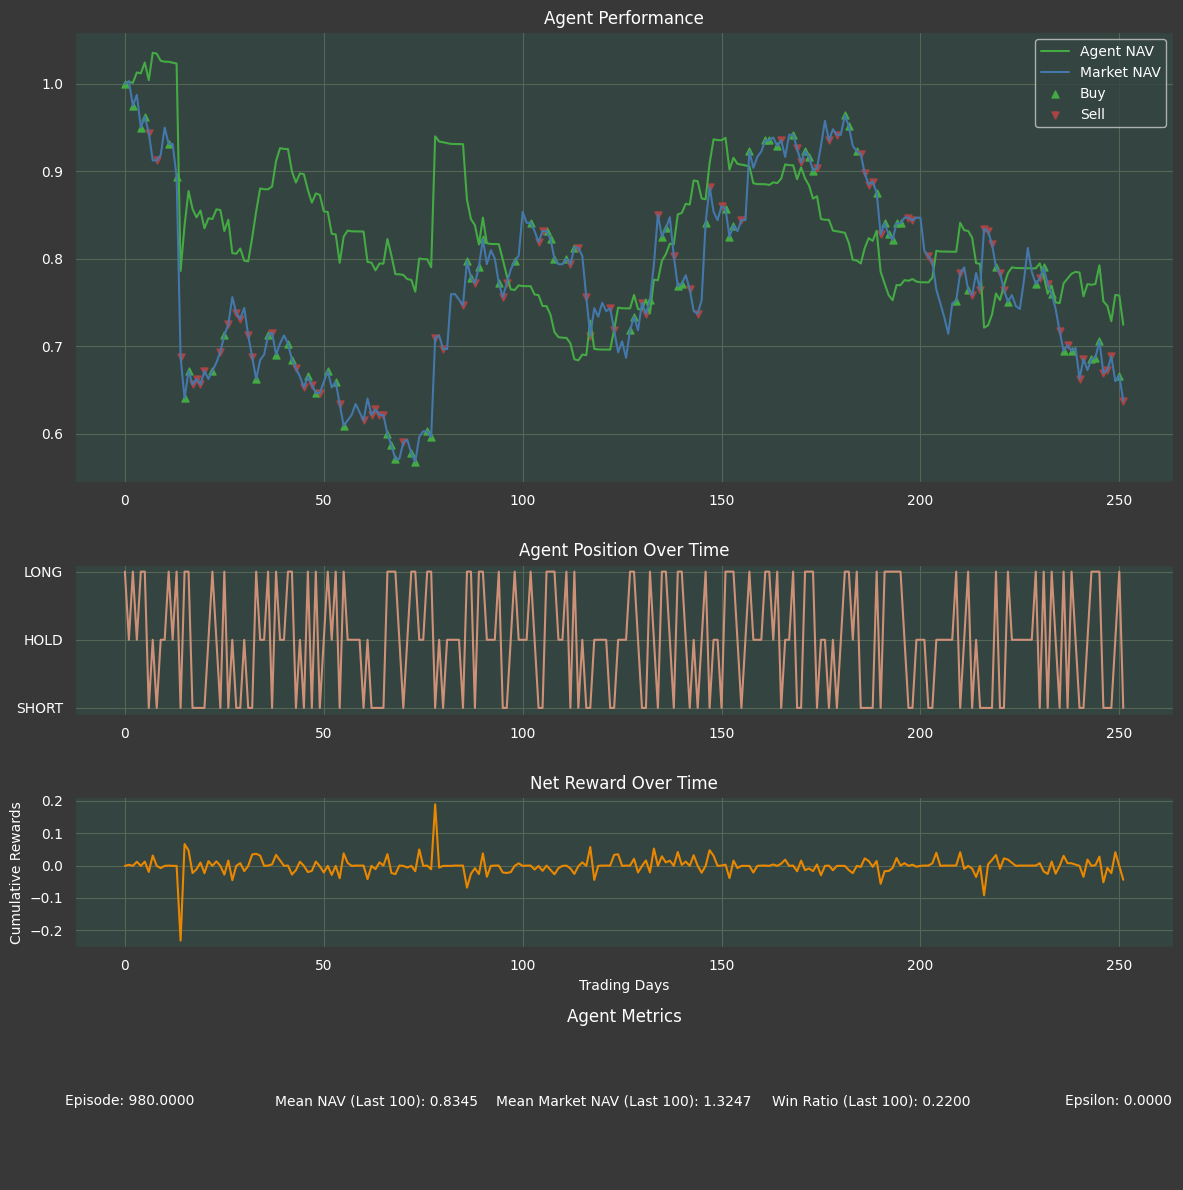

In [ ]:
total_steps = 0
max_episodes = 1000

episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

start = time()  # Assuming you've imported time module
results = []

for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)

        ddqn.memorize_transition(this_state,
                                 action,
                                 reward,
                                 next_state,
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    # get DataFrame with sequence of actions, returns and nav values
    result = trading_environment.env.simulator.result()

    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav
    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    # market nav
    market_nav = final.market_nav
    market_navs.append(market_nav)

    # track difference between agent and market NAV results
    diff = nav - market_nav
    diffs.append(diff)

    if episode % 10 == 0:
        # Render the environment directly instead of using track_results
        trading_environment.render(episode, mode='human', navs=navs, market_navs=market_navs, diffs=diffs, epsilon=ddqn.epsilon)
        clear_output(wait=True)  # To refresh the cell with updated plots

    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()


In [ ]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()

results.to_csv(results_path / 'results.csv', index=False)

with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()


In [ ]:
# Plot performance results
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'performance', dpi=300)
